<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_02_CoronaVirus_Conv2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 2: CoronaVirus -Conv2019 Analysis

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
#!pip install geopy

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from geopy.geocoders import Nominatim

In [0]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [0]:
import plotly
import plotly.express as px

In [0]:
#import os
#print(os.listdir("input"))

## Exploratory Data Analysis

### Data download

Data source: https://github.com/CSSEGISandData/COVID-19

In [0]:
githubLoc = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

In [7]:
from datetime import date, timedelta

sdate = date(2020, 1, 22)   # start date
edate = date.today()   # end date

delta = edate - sdate       # as timedelta

appended_data = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    #print(day.strftime('%m-%d-%Y'))
    try:
      df = pd.read_csv(githubLoc + day.strftime('%m-%d-%Y')+".csv", parse_dates=True)
      appended_data.append(df)
    except:
      pass
df_corona = pd.concat(appended_data)
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [8]:
df_corona.tail(10)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered
215,1.0,US,0.0,2020-03-05,35.9179,-86.8622,"Williamson County, TN",0.0
216,1.0,US,0.0,2020-03-06,38.7646,-121.9018,"Yolo County, CA",0.0
217,1.0,Ukraine,0.0,2020-03-03,48.3794,31.1656,NaN,0.0
218,1.0,Vatican City,0.0,2020-03-06,41.9029,12.4534,NaN,0.0
219,0.0,Australia,0.0,2020-02-29,35.4437,139.6380,From Diamond Princess,0.0
220,0.0,Australia,0.0,2020-03-06,-12.4634,130.8456,Northern Territory,0.0
221,0.0,US,0.0,2020-02-24,29.3829,-98.6134,"Lackland, TX (From Diamond Princess)",0.0
222,0.0,US,0.0,2020-03-07,30.3213,-95.4778,"Montgomery County, TX",0.0
223,0.0,US,0.0,2020-02-24,41.2545,-95.9758,"Omaha, NE (From Diamond Princess)",0.0
224,0.0,US,0.0,2020-02-24,38.2721,-121.9399,"Travis, CA (From Diamond Princess)",0.0


In [0]:
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona["Date"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona['Country/Region'].replace({'Mainland China':'China'},inplace=True)
df_corona.fillna(value=0, inplace=True)


### Show Cases by Date

In [10]:
df_byDate = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date")
df_byDate["mort_Rate"] =(df_byDate["Deaths"]/df_byDate["Confirmed"])*100
df_byDate.tail(10)

,Confirmed,Deaths,Latitude,Longitude,Recovered,mort_Rate
Date,,,,,,
2020-02-27,82520.0,2816.0,665.7053,-356.7509,33683.0,3.412506
2020-02-28,83698.0,2867.0,1038.8248,424.1723,36268.0,3.425410
2020-02-29,86498.0,2942.0,717.7896,1856.7943,39634.0,3.401235
2020-03-01,87609.0,2994.0,3661.7756,5536.3878,42695.0,3.417457
2020-03-02,91382.0,3091.0,4572.4116,4240.8240,46201.0,3.382504
2020-03-03,94682.0,3176.0,5291.5061,1382.7588,48705.0,3.354386
2020-03-04,93948.0,3248.0,4036.2221,3724.5211,50728.0,3.457232
2020-03-05,97144.0,3346.0,4199.5013,2675.3771,53877.0,3.444371
2020-03-06,103222.0,3463.0,5595.2459,1786.4661,56712.0,3.354905


### Number of Cases in China

In [0]:
#df_corona.groupby(by="Date").sum().reset_index().sort_values(by="Date").diff()

In [12]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China = df_corona.loc[df_corona["Country/Region"] == "China"].groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China.tail()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-03-03,-179.0,33.0,-35.0121,-176.4836,2406.0
2020-03-04,-535.0,30.0,-200.2920,-690.3178,1858.0
2020-03-05,383.0,38.0,158.2314,577.1216,2690.0
2020-03-06,934.0,20.0,-101.0717,-361.9631,2353.0
2020-03-07,-2729.0,12.0,-233.6489,-776.4545,-1197.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



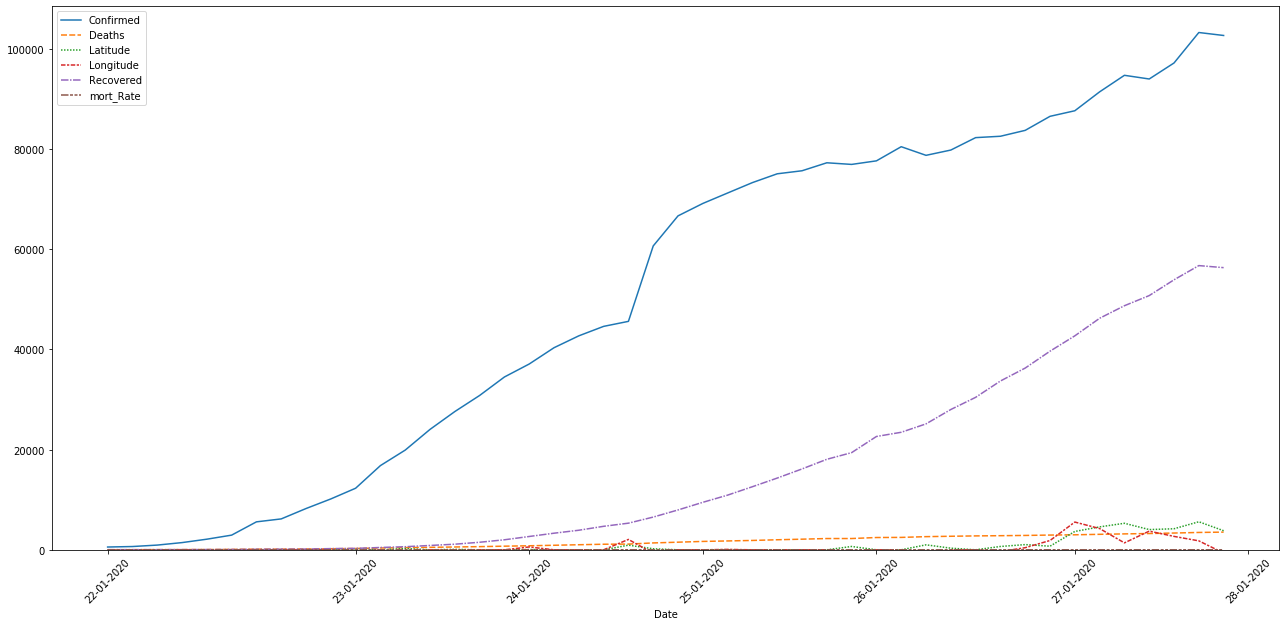

In [13]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=df_byDate)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

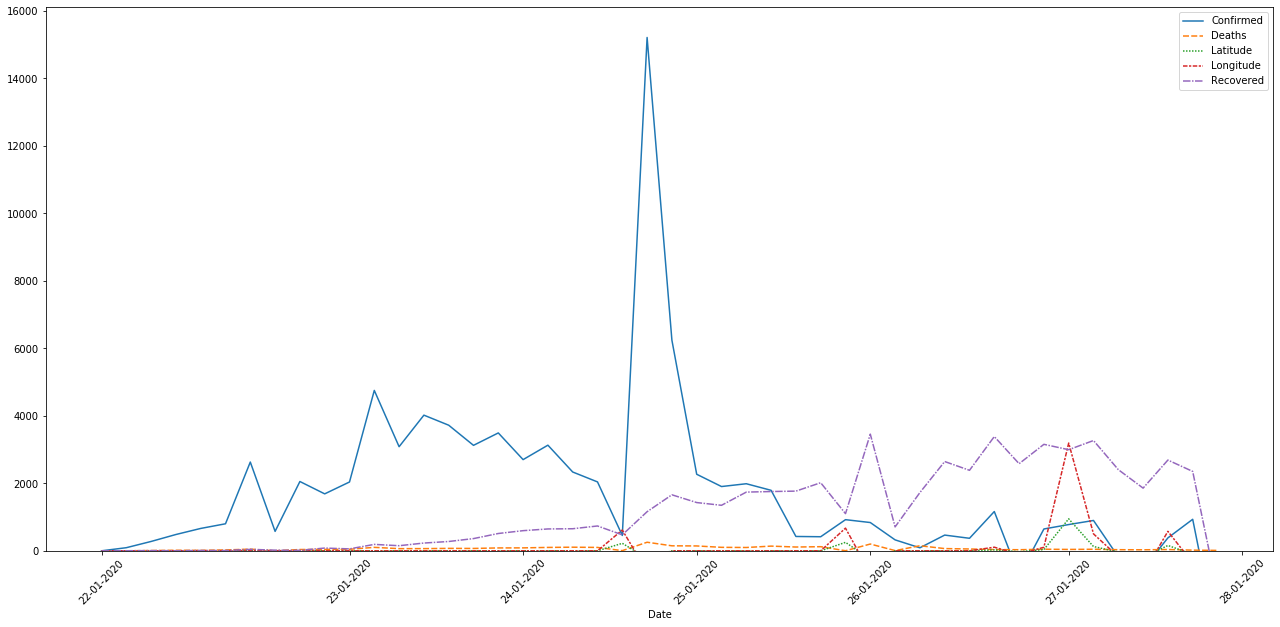

In [14]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=nb_cases_day_China)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

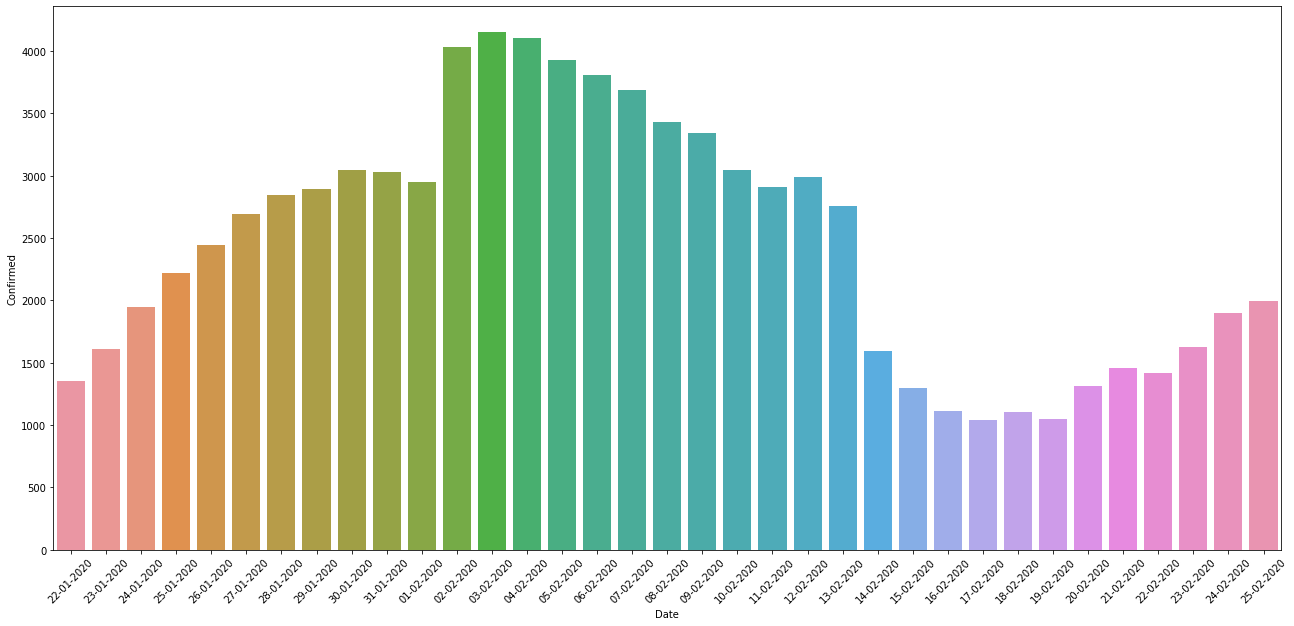

In [15]:
fig, ax = plt.subplots(figsize = (22,10))    
fig = sns.barplot(
    x = "Date", 
    y = "Confirmed", 
    data = nb_cases_day.rolling(window=12).mean().dropna().reset_index())

fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [16]:
df_corona["Date"].max()

Timestamp('2020-03-07 00:00:00')

In [17]:
df_corona.describe()

,Confirmed,Deaths,Latitude,Longitude,Recovered
count,3992.000000,3992.000000,3992.000000,3992.000000,3992.000000
mean,596.859719,17.697395,9.348819,4.623120,184.713928
std,5077.013850,190.407003,18.301672,48.949587,1908.626875
min,0.000000,0.000000,-41.454500,-157.858400,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,0.000000,0.000000,1.000000
75%,106.000000,1.000000,19.195900,0.000000,17.000000
max,67666.000000,2959.000000,64.963100,174.886000,43500.000000


### Dataframe Info

In [18]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992 entries, 0 to 224
Data columns (total 9 columns):
Confirmed         3992 non-null float64
Country/Region    3992 non-null object
Deaths            3992 non-null float64
Last Update       3992 non-null datetime64[ns]
Latitude          3992 non-null float64
Longitude         3992 non-null float64
Province/State    3992 non-null object
Recovered         3992 non-null float64
Date              3992 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 311.9+ KB


In [19]:
#**Present Gobal condition: confirmed, death and recovered**
print('Data from Day: ' + str(df_corona["Date"].max().strftime('%A %m/%d/%Y')))
print('Globally Confirmed Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Confirmed'].sum())
print('Global Deaths: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Deaths'].sum())
print('Globally Recovered Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Recovered'].sum())

Data from Day: Saturday 03/07/2020
Globally Confirmed Cases:  102630.0
Global Deaths:  3530.0
Globally Recovered Cases:  56302.0


In [20]:
df_corona[['Date','Country/Region','Province/State','Confirmed','Deaths','Recovered']].drop_duplicates(subset=["Date","Province/State"]).groupby(['Date','Country/Region']).sum()

Confirmed  Deaths  Recovered
Date       Country/Region                              
2020-01-22 China               547.0    17.0       28.0
           Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
...                              ...     ...        ...
2020-03-07 Canada               52.0     0.0        7.0
           China             78619.0  3051.0    53511.0
           Hong Kong           108.0     2.0       51.0
           South Korea        7041.0    44.0      135.0
           US                  311.0    16.0        5.0

[294 rows x 3 columns]

In [21]:
df_corona.loc[df_corona["Date"]==df_corona["Date"].max()].groupby('Country/Region')['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

,Confirmed,Deaths,Recovered
Country/Region,,,
China,78619.0,3051.0,53511.0
South Korea,7041.0,44.0,135.0
Italy,5883.0,233.0,589.0
Iran,5823.0,145.0,1669.0
France,949.0,11.0,12.0
Germany,799.0,0.0,18.0
Spain,500.0,10.0,30.0
Japan,461.0,6.0,76.0
US,311.0,16.0,5.0


In [22]:
df_corona.loc[df_corona["Country/Region"] == "China"].groupby("Date").sum()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-01-22,547.0,17.0,0.0000,0.0000,28.0
2020-01-23,639.0,18.0,0.0000,0.0000,30.0
2020-01-24,916.0,26.0,0.0000,0.0000,36.0
2020-01-25,1399.0,42.0,0.0000,0.0000,39.0
2020-01-26,2062.0,56.0,0.0000,0.0000,49.0
2020-01-27,2863.0,82.0,0.0000,0.0000,58.0
2020-01-28,5494.0,131.0,0.0000,0.0000,101.0
2020-01-29,6070.0,133.0,0.0000,0.0000,120.0
2020-01-30,8124.0,171.0,0.0000,0.0000,135.0


In [23]:
CasesByCountry = df_corona.groupby(by=['Country/Region','Date'])['Confirmed','Deaths','Recovered'].sum().reset_index()
CasesByCountry.loc[CasesByCountry["Date"] == CasesByCountry["Date"].max()]
CasesByCountry.loc[CasesByCountry["Date"] == '2020-02-23']

,Country/Region,Date,Confirmed,Deaths,Recovered
151,China,2020-02-23,77065.0,2445.0,23253.0
312,Hong Kong,2020-02-23,74.0,2.0,11.0
355,Iran,2020-02-23,43.0,8.0,0.0
369,Iraq,2020-02-23,0.0,0.0,0.0
400,Italy,2020-02-23,155.0,3.0,2.0
443,Japan,2020-02-23,147.0,1.0,22.0
598,Others,2020-02-23,2073.0,9.0,0.0
688,Singapore,2020-02-23,178.0,0.0,102.0
730,South Korea,2020-02-23,602.0,6.0,18.0
808,Taiwan,2020-02-23,28.0,1.0,2.0


In [24]:
pivotTableCorna = pd.pivot_table(df_corona,index="Country/Region", columns="Date", values="Confirmed" ,fill_value=0,aggfunc='sum').reset_index()
pivotTableCorna

Date,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00
0,Azerbaijan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,3,5,24,0,34,0
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0
4,Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,US,1,1,2,2,5,5,5,5,5,6,141,0,104,0,27,0,0,0,62,0,2,0,40,0,0,0,0,0,0,0,82,36,0,36,47,84,20,139,15,15,347,116,74,186,202,311
101,Ukraine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0
102,United Arab Emirates,0,0,0,0,0,0,0,4,4,8,0,30,0,0,0,0,0,14,0,16,0,24,0,0,8,54,0,0,0,0,0,78,0,0,0,0,0,19,63,0,0,54,0,58,0,45
103,Vatican City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


In [0]:
#f, ax = plt.subplots(figsize=(17, 15))
#ax = sns.heatmap(pivotTableCorna)

In [26]:
CasesByCountry.tail()

,Country/Region,Date,Confirmed,Deaths,Recovered
928,Vietnam,2020-02-11,30.0,0.0,12.0
929,Vietnam,2020-02-13,128.0,0.0,56.0
930,Vietnam,2020-02-21,64.0,0.0,56.0
931,Vietnam,2020-02-25,176.0,0.0,176.0
932,Vietnam,2020-03-07,18.0,0.0,16.0


In [27]:
CasesByCountry["Date"].max()

Timestamp('2020-03-07 00:00:00')

In [28]:
df_corona.loc[
              df_corona["Date"]==df_corona["Date"].max()].groupby(
                  ['Province/State'])['Confirmed','Deaths','Recovered'].sum().sort_values(
                      by="Confirmed", ascending=False).head(10)

,Confirmed,Deaths,Recovered
Province/State,,,
Hubei,67666.0,2959.0,43500.0
0,23501.0,460.0,2717.0
Guangdong,1352.0,7.0,1237.0
Henan,1272.0,22.0,1244.0
Zhejiang,1215.0,1.0,1154.0
Hunan,1018.0,4.0,960.0
Jiangxi,935.0,1.0,916.0
Shandong,758.0,6.0,627.0
Jiangsu,631.0,0.0,606.0


In [0]:
df_corona2 = df_corona.groupby(['Date','Country/Region'])['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

In [0]:
df_corona2.reset_index(inplace=True)

In [31]:
fig = px.bar(
    df_corona2[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [0]:
df_corona3 =df_corona2.loc[df_corona2["Country/Region"] !="China"]

In [33]:
fig = px.bar(
    df_corona3[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [34]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Confirmed', hover_data=['Province/State', 'Deaths', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [35]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date"), 
             x='Date', y='Confirmed', 
             hover_data=['Deaths', 'Recovered'])
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Singapore',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [36]:
fig = px.bar(df_corona, x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for each country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [37]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

## Predicting Using Facebook Prophet vs Sklearn

In [0]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

In [0]:
confirmed_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#confirmed_training_dataset

In [40]:
# Making the Model
prophet = Prophet()
prophet.fit(confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=37)
confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
fig = plot_plotly(prophet, confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
death_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Deaths'].sum().reset_index()).rename(columns={'Date': 'ds', 'Deaths': 'y'})
#death_training_dataset

In [43]:
# Making the Model
prophet = Prophet()
prophet.fit(death_training_dataset)
future = prophet.make_future_dataframe(periods=30)
deaths_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
fig = plot_plotly(prophet, deaths_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions of Deaths',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
sg_confirmed_training_dataset = pd.DataFrame(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#sg_confirmed_training_dataset

In [46]:
# Making the Model
prophet = Prophet()
prophet.fit(sg_confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=30)
sg_confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
fig = plot_plotly(prophet, sg_confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

### Number of cases per day

### Prediction Singapore Cases Per Day

In [0]:
df_corona_cases_day_sg =df_corona.loc[df_corona["Country/Region"] == "Singapore"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [0]:
SG_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_sg.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#SG_CasesPerDay_training_dataset

In [50]:
# Making the Model
prophet = Prophet()
prophet.fit(SG_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
SG_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
fig = plot_plotly(prophet, SG_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Singapore Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

2.2746193285654157
0.3738455056532576


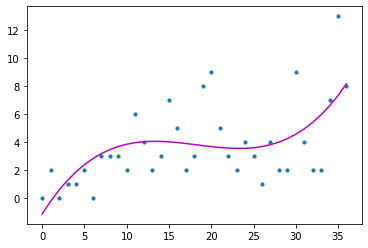

In [52]:
x = np.arange(0, SG_CasesPerDay_training_dataset.shape[0], dtype=int)
y = SG_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### China Prediction Cases Per Day

In [0]:
df_corona_cases_day_cn = df_corona.loc[df_corona["Country/Region"] == "China"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()

In [0]:
CN_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_cn.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#CN_CasesPerDay_training_dataset

In [55]:
# Making the Model
prophet = Prophet()
prophet.fit(CN_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
CN_CasesPerDay_forecast = prophet.predict(future)
#CN_CasesPerDay_forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
fig = plot_plotly(prophet, CN_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='China Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

2108.513330773663
0.20844638877925492


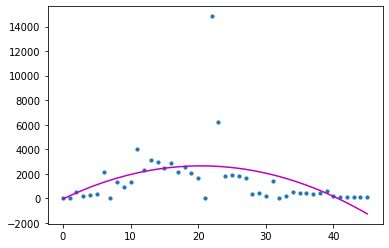

In [57]:
x = np.arange(0, CN_CasesPerDay_training_dataset.shape[0], dtype=int)
y = CN_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Prediction Spain Confirmed

In [0]:

df_corona_cases_day_spain =df_corona.loc[df_corona["Country/Region"] == "Spain"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [0]:
Spain_CasesPerDay_training_dataset = pd.DataFrame(df_corona.loc[
                                                                (df_corona["Country/Region"] == "Spain")&(df_corona["Date"] > "20200215")].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})

In [94]:
# Making the Model
prophet = Prophet()
prophet.fit(Spain_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=120)
Spain_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 8.


In [95]:
fig = plot_plotly(prophet, Spain_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Singapore Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

11.656761251740688
0.9943757257704827


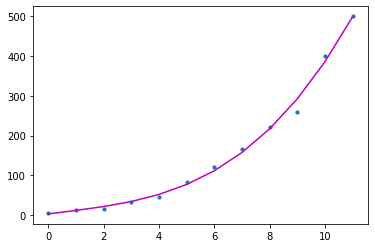

In [96]:
x = np.arange(0, Spain_CasesPerDay_training_dataset.shape[0], dtype=int)
y = Spain_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Calculate Mortality Rate
By Country/Date

In [97]:
df_corona.groupby("Date").sum()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-01-22,555.0,17.0,0.0000,0.0000,28.0
2020-01-23,653.0,18.0,0.0000,0.0000,30.0
2020-01-24,941.0,26.0,0.0000,0.0000,36.0
2020-01-25,1438.0,42.0,0.0000,0.0000,39.0
2020-01-26,2118.0,56.0,0.0000,0.0000,52.0
2020-01-27,2927.0,82.0,0.0000,0.0000,61.0
2020-01-28,5578.0,131.0,0.0000,0.0000,107.0
2020-01-29,6165.0,133.0,0.0000,0.0000,126.0
2020-01-30,8235.0,171.0,0.0000,0.0000,143.0


In [98]:
df_corona_MortRate = df_corona.groupby(by=["Date"]).sum().reset_index()
df_corona_MortRate

,Date,Confirmed,Deaths,Latitude,Longitude,Recovered
0,2020-01-22,555.0,17.0,0.0000,0.0000,28.0
1,2020-01-23,653.0,18.0,0.0000,0.0000,30.0
2,2020-01-24,941.0,26.0,0.0000,0.0000,36.0
3,2020-01-25,1438.0,42.0,0.0000,0.0000,39.0
4,2020-01-26,2118.0,56.0,0.0000,0.0000,52.0
5,2020-01-27,2927.0,82.0,0.0000,0.0000,61.0
6,2020-01-28,5578.0,131.0,0.0000,0.0000,107.0
7,2020-01-29,6165.0,133.0,0.0000,0.0000,126.0
8,2020-01-30,8235.0,171.0,0.0000,0.0000,143.0
9,2020-01-31,10151.0,213.0,0.0000,0.0000,239.0


In [0]:
df_corona_MortRate["MortalityRate"] = df_corona_MortRate["Deaths"]/df_corona_MortRate["Confirmed"]
df_corona_MortRate["MortalityRate"].replace([np.inf, -np.inf], np.nan)
df_corona_MortRate["MortalityRate"].fillna(value=0, inplace=True)


In [0]:
#df_corona_MortRate["MortalityRate"].loc[(~np.isfinite(df_corona_MortRate["MortalityRate"])) & df_corona_MortRate["MortalityRate"].notnull()] = 0

In [100]:
df_corona_MortRate.sort_values(by="Date", ascending=False)

,Date,Confirmed,Deaths,Latitude,Longitude,Recovered,MortalityRate
45,2020-03-07,102630.0,3530.0,3809.8282,-662.2459,56302.0,0.034395
44,2020-03-06,103222.0,3463.0,5595.2459,1786.4661,56712.0,0.033549
43,2020-03-05,97144.0,3346.0,4199.5013,2675.3771,53877.0,0.034444
42,2020-03-04,93948.0,3248.0,4036.2221,3724.5211,50728.0,0.034572
41,2020-03-03,94682.0,3176.0,5291.5061,1382.7588,48705.0,0.033544
40,2020-03-02,91382.0,3091.0,4572.4116,4240.8240,46201.0,0.033825
39,2020-03-01,87609.0,2994.0,3661.7756,5536.3878,42695.0,0.034175
38,2020-02-29,86498.0,2942.0,717.7896,1856.7943,39634.0,0.034012
37,2020-02-28,83698.0,2867.0,1038.8248,424.1723,36268.0,0.034254
36,2020-02-27,82520.0,2816.0,665.7053,-356.7509,33683.0,0.034125


### Geolocation 1

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "bghai19" # username from the json file
os.environ['KAGGLE_KEY'] = "4947c3935b9ad98eacd876741ff7c11c" # key from the json file

In [64]:
!kaggle datasets download -d parulpandey/world-coordinates

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 2.06MB/s]


In [0]:
import zipfile

In [0]:
with zipfile.ZipFile("/content/world-coordinates.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [67]:
# Importing the world_coordinates dataset
world_coordinates = pd.read_csv('/content/input/world_coordinates.csv')
world_coordinates.tail()


,Code,Country,latitude,longitude
239,YE,Yemen,15.552727,48.516388
240,YT,Mayotte,-12.827500,45.166244
241,ZA,South Africa,-30.559482,22.937506
242,ZM,Zambia,-13.133897,27.849332
243,ZW,Zimbabwe,-19.015438,29.154857


In [68]:
# Merging the coordinates dataframe with original dataframe
df_corona_world = pd.merge(world_coordinates,df_corona,left_on='Country',right_on='Country/Region')
df_corona_world = df_corona_world.loc[df_corona_world["Date"] == df_corona_world["Date"].max()]
df_corona_world= df_corona_world.groupby(by=["Date","Country/Region","latitude","longitude"]).sum().reset_index()
df_corona_world

,Date,Country/Region,latitude,longitude,Confirmed,Deaths,Latitude,Longitude,Recovered
0,2020-03-07,Argentina,-38.416097,-63.616672,8.0,0.0,-38.4161,-63.6167,0.0
1,2020-03-07,Australia,-25.274398,133.775136,39.0,1.0,-71.6824,296.1724,11.0
2,2020-03-07,Austria,47.516231,14.550072,79.0,0.0,47.5162,14.5501,0.0
3,2020-03-07,Azerbaijan,40.143105,47.576927,9.0,0.0,40.1431,47.5769,0.0
4,2020-03-07,Bahrain,25.930414,50.637772,85.0,0.0,26.0275,50.5500,4.0
5,2020-03-07,Belgium,50.503887,4.469936,169.0,0.0,50.8333,4.0000,1.0
6,2020-03-07,Bosnia and Herzegovina,43.915886,17.679076,3.0,0.0,43.9159,17.6791,0.0
7,2020-03-07,Canada,56.130366,-106.346771,52.0,0.0,191.9837,-389.5650,7.0
8,2020-03-07,China,35.861660,104.195397,78619.0,3051.0,699.1714,2374.4402,53511.0
9,2020-03-07,Colombia,4.570868,-74.297333,1.0,0.0,4.5709,-74.2973,0.0


In [0]:
#df_corona_world.info()

In [0]:
import plotly.express as px
import plotly.graph_objects as go

In [71]:
fig = go.Figure(data=go.Scattergeo(
        #locationmode = 'iso_alpha',
        lon = df_corona_world['longitude'],
        lat = df_corona_world['latitude'],
        text = df_corona_world['Country/Region'] + " " + df_corona_world['Confirmed'].astype(str) + ' Confirmed Cases',
        mode = 'markers',
        marker = dict(
            size = 12,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df_corona_world['Confirmed'],
            cmax = df_corona_world['Confirmed'].max(),
            colorbar_title="Cases by" + str(df_corona_world['Date'].max())
        )))

fig.update_layout(
        title = 'Corona Virus by Country)',
        geo = dict(
            scope='world',
            #projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [72]:

scl = [0,"#000000"],[0.5,"rgb(255, 0, 0)"],[1,"rgb(150, 204, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lon = df_corona_world['longitude'],
    lat = df_corona_world['latitude'], 
    text = df_corona_world['Country/Region'] + " " +df_corona_world['Confirmed'].astype(str),
    marker = dict(
        color = df_corona_world['Confirmed'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = (df_corona_world['Confirmed']/2000)+10
    )
))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(242, 242, 242)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,


    ),
    title='CoronaViruse cases ' + df_corona_world['Date'].max().strftime('%A %m/%d/%Y'),
)
fig.show()

### Geolocation2

In [0]:
import folium 
from folium import plugins

In [74]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3)

for lat, lon, value, name, deaths in zip(df_corona_world['latitude'], df_corona_world['longitude'], df_corona_world['Confirmed'], df_corona_world['Country/Region'], df_corona_world['Deaths']):
    folium.CircleMarker([lat, lon],
                        radius=1+(deaths/100),
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map